In [ ]:
# Import modules
import tensorflow as tf
import keras as K
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from keras.models import load_model

import pandas as pd
import numpy as np
import PIL
import logging
import os

import zipfile
import shutil

from datetime import datetime

# for figures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sns

# for the Grad-CAMs
from IPython.display import Image, display
import matplotlib.cm as cm

# Working Directory on A4 Computer (GoPro and V2 data are on the A4 Computer)
files = os.listdir()

os.chdir("/home/scott/Dropbox/IMAGINE Project/MSSI_Project/")
cwd = os.getcwd()
print("Current working directory:", cwd)

# This code allows GPU memory allocation to grow as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
#  Prints the Tensorflow, Keras versions, and number of GPUs
print(tf.__version__)
print(K.__version__)
# print("TensorFlow Hub version:", hub.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
2.14.0
Num GPUs Available:  4


In [5]:
from platform import python_version

print(python_version())

3.9.19


In [1]:
!nvidia-smi

Sat Jun 22 19:19:39 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     On   | 00000000:05:00.0  On |                  N/A |
| 23%   40C    P5    23W / 250W |    246MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN Xp     On   | 00000000:06:00.0 Off |                  N/A |
| 23%   

In [6]:
#This compiled file incorporate all existing data with GoPro in training set only

metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_04252024.csv", low_memory=False)
# Train: 100% GoPro + 80% Imagine V2 and V3
# Val: 10% Imagine V2 and V3
# Tst: 10% Imagine V2 and V3

In [18]:
# Check for NaNs in the entire DataFrame
# print(metadata.isna().sum())

In [16]:
# Ensure no NaNs in data
# assert not np.any(np.isnan(metadata['ln_ufp_num_10s_ma_image_label_raw']))
# assert not np.any(np.isnan(metadata[image_path]))

In [19]:
# print(metadata['image_path'][200000])

In [7]:
# Look at data
metadata.head(10)

,datetime,image_path,audio_path,ln_ufp_num_10s_ma_image_label_raw,ln_ufp_num_10s_ma_spec_label_raw,ln_ufp_size_10s_ma_image_label_raw,ln_ufp_size_10s_ma_spec_label_raw,ln_noise_10s_ma_image_label_raw,ln_noise_10s_ma_spec_label_raw,ufp_num_10s_ma_image_label_raw,...,ufp_size_10s_ma_spec_label_quartile,ufp_size_10s_ma_image_label_quartile,image_extension,audio_extension,image_name,audio_name,pair_pm25,set_V3ext,set,vsby_nm
0,2019-04-23T10:20:27Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.744668,9.744668,3.098740,3.098740,4.319752,4.319752,17063.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
1,2019-04-23T10:20:28Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.710145,9.710145,3.119276,3.119276,4.309322,4.309322,16484.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
2,2019-04-23T10:20:29Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.683153,9.683153,3.144583,3.144583,4.327702,4.327702,16045.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
3,2019-04-23T10:20:30Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.583558,9.583558,3.167583,3.167583,4.320018,4.320018,14524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
4,2019-04-23T10:20:31Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.509259,9.509259,3.184698,3.184698,4.303119,4.303119,13484.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
5,2019-04-23T10:20:32Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.479069,9.479069,3.197448,3.197448,4.277360,4.277360,13083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
6,2019-04-23T10:20:33Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.422544,9.422544,3.211650,3.211650,4.273606,4.273606,12364.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
7,2019-04-23T10:20:34Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.399638,9.399638,3.223664,3.223664,4.260000,4.260000,12084.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
8,2019-04-23T10:20:35Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.403107,9.403107,3.235536,3.235536,4.227709,4.227709,12126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
9,2019-04-23T10:20:36Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.406976,9.406976,3.241029,3.241029,4.200804,4.200804,12173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0


In [8]:
# How much data in trn, val, tst sets for metadata_random_split

metadata.set.value_counts()

set
trn    345680
val     22407
tst     22223
Name: count, dtype: int64

In [9]:
#Select input file type (this tells python where to look for the file paths)
file = input("What input are you using: images, or spectrograms? ")

if file == 'images':
    file = 'image_path'
else:
  if file == 'spectrograms':
      file = 'audio_path'
  else:
    print('!!!TYPO in input_data name')

What input are you using: images, or spectrograms?  spectrograms


In [10]:
# Define Initial Learning Rate
initial_learning_rate = 1e-4
meta_data_name = "gp_v2_v3_Training_Only"

In [11]:
# Model architectures
architecture = input("What architecture do you want to use: ConvNeXT_linear_AdamW_Base, ConvNeXT_linear_AdamW_Large, ConvNeXt_Tiny_linear_AdamW, ResNet50_AdamW_Nadam ?")
from tensorflow.keras import backend as Kb

# For debugging 'Nan' values
def custom_mse(y_true, y_pred):
    loss = Kb.mean(Kb.square(y_true - y_pred), axis=-1)
    tf.print("y_true:", y_true)
    tf.print("y_pred:", y_pred)
    tf.print("loss:", loss)
    return loss
    
if architecture == 'ConvNeXT_linear_AdamW_Base':
    architecture_preprocessing = K.applications.convnext.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ConvNeXtBase(model_name="convnext_base",include_top=False, weights="imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units=1, activation='linear')(model_output) 
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.AdamW(learning_rate=initial_learning_rate),
            loss='mse',
            metrics=['mae']
        )
        return model

elif architecture == 'ConvNeXT_linear_AdamW_Large':
    architecture_preprocessing = K.applications.convnext.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ConvNeXtLarge(include_top=False, weights="imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units=1, activation='linear')(model_output)
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.AdamW(learning_rate=initial_learning_rate),
            loss='mse',
            metrics=['mae']
        )
        return model

elif architecture == 'ConvNeXt_Tiny_AdamW_Nadam':
    architecture_preprocessing = K.applications.convnext.preprocess_input

    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ConvNeXtTiny(include_top=False, weights="imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units=1, activation='linear')(model_output)
    
        # Learning rate schedule
        initial_learning_rate = 1e-5
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=10000,
            alpha=0.0
        )
        optimizer = K.optimizers.AdamW(learning_rate=lr_schedule, clipnorm=1.0)
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=optimizer,
            loss='mean_squared_error',
            metrics=['mae']
        )
        return model

elif architecture == 'ResNet50_AdamW_Nadam':
    architecture_preprocessing = K.applications.resnet50.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ResNet50(include_top=False, weights= "imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units= 1, activation='linear')(model_output) 
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.AdamW(learning_rate = initial_learning_rate),
            loss = custom_mse,
            metrics = ['mae']
        )
        return model
                        
else:
    print('!!!TYPO in architecture name')

What architecture do you want to use: ConvNeXT_linear_AdamW_Base, ConvNeXT_linear_AdamW_Large, ConvNeXt_Tiny_linear_AdamW, ResNet50_AdamW_Nadam ? ConvNeXT_linear_AdamW_Base


In [12]:
# Select Exposure to be modelled
cwd = os.getcwd()
print("Current working directory:", cwd)

target = input("What do you want to model: ln_noise_10s_ma_spec_label_raw, ln_noise_10s_ma_image_label_raw, ln_ufp_num_10s_ma_spec_label_raw, ln_ufp_num_10s_ma_image_label_raw, ln_ufp_size_10s_ma_image_label_raw, ln_ufp_size_10s_ma_spec_label_raw ?")                  

if target == 'ln_noise_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # file = image_path or audio_path
                                                y_col= target,  # taget = exposure to be modelled
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=64,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

elif target == 'ln_noise_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=64,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_num_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=64,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

    
    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

elif target == 'ln_ufp_num_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=64,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')    
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_size_10s_ma_image_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=64,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)
 
    
    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
elif target == 'ln_ufp_size_10s_ma_spec_label_raw':

    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                     horizontal_flip=True,
                                                     vertical_flip = False)
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='trn', [target, file]].reset_index(drop=True),  
                                                x_col= file, # 
                                                y_col= target,  # 
                                                class_mode = 'raw', 
                                                target_size=(256, 256), # all of our images will be resized to 256 x 256
                                                color_mode='rgb', 
                                                batch_size=64,
                                                shuffle=True)
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['set']=='val', [target, file]].reset_index(drop=True),
                                                     x_col= file,
                                                     y_col=target,
                                                     class_mode='raw',
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

    # Define callbacks
    csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')
    model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
else:
    print('!!!TYPO in exposure name') 

Current working directory: /home/scott/Dropbox/IMAGINE Project/MSSI_Project


What do you want to model: ln_noise_10s_ma_spec_label_raw, ln_noise_10s_ma_image_label_raw, ln_ufp_num_10s_ma_spec_label_raw, ln_ufp_num_10s_ma_image_label_raw, ln_ufp_size_10s_ma_image_label_raw, ln_ufp_size_10s_ma_spec_label_raw ? ln_ufp_num_10s_ma_spec_label_raw


Found 345680 validated image filenames.
Found 22407 validated image filenames.


In [13]:
# # Retrieve a batch from the train generator
# x_batch, y_batch = next(train_generator)

# # Print the shape of the batch
# print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")

# # Print and visualize some samples from the batch
# num_samples_to_display = 5  # Number of samples to display

# for i in range(num_samples_to_display):
#     plt.imshow(x_batch[i].astype('uint8'))  # Convert to uint8 if necessary
#     plt.title(f"Label: {y_batch[i]}")
#     plt.axis('off')
#     plt.show()

In [15]:
# Retrieve a batch from the validate generator
# x_val_batch, y_val_batch = next(validate_generator)

# # Print the shape of the batch
# print(f"x_val_batch shape: {x_val_batch.shape}, y_val_batch shape: {y_val_batch.shape}")

# # Print and visualize some samples from the batch
# num_samples_to_display = 5  # Number of samples to display

# for i in range(num_samples_to_display):
#     plt.imshow(x_val_batch[i].astype('uint8'))  # Convert to uint8 if necessary
#     plt.title(f"Label: {y_val_batch[i]}")
#     plt.axis('off')
#     plt.show()

In [30]:
# Check a batch from the train generator
# x_batch, y_batch = next(train_generator)
# print(np.isnan(x_batch).any(), np.isnan(y_batch).any())

# # Check a batch from the validate generator
# x_batch, y_batch = next(validate_generator)
# print(np.isnan(x_batch).any(), np.isnan(y_batch).any())

In [ ]:
#Train the model

# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope.
with strategy.scope():
    model = get_compiled_model()
    

#Fit Model
model.fit(train_generator,
          validation_data=validate_generator,
          epochs=10,
          steps_per_epoch=int(np.ceil(train_generator.samples/train_generator.batch_size)),
          validation_steps=int(np.ceil(validate_generator.samples/validate_generator.batch_size)),
          callbacks=[csv_logger, 
                     reduce_lr_on_plateau, 
                     model_checkpoint,
                     early_stopping] 
         )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2024-06-22 19:23:10.364448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11164 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:05:00.0, compute capability: 6.1
2024-06-22 19:23:10.365032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11409 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:06:00.0, compute capability: 6.1
2024-06-22 19:23:10.365516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11409 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:09:00.0, compute capability: 6.1
2024-06-22 19:23:10.365993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11410 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:0a:00.0, comp

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 344 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 344 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost

2024-06-22 19:26:53.930689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-06-22 19:26:54.621035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-06-22 19:26:54.840753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-06-22 19:26:55.246215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-06-22 19:26:55.923292: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd256a304f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-22 19:26:55.923325: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2024-06-22 19:26:55.923333: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
2024-06-22 19:26:55.923340: I tensorflow/

5402/5402 [==============================] - ETA: 0s - loss: 0.4129 - mae: 0.4589INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


5402/5402 [==============================] - 5210s 918ms/step - loss: 0.4129 - mae: 0.4589 - val_loss: 0.4820 - val_mae: 0.5239 - lr: 1.0000e-04
Epoch 2/10
5402/5402 [==============================] - ETA: 0s - loss: 0.2702 - mae: 0.3542INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


5402/5402 [==============================] - 4969s 920ms/step - loss: 0.2702 - mae: 0.3542 - val_loss: 0.4198 - val_mae: 0.4859 - lr: 1.0000e-04
Epoch 3/10
1190/5402 [=====>........................] - ETA: 1:01:17 - loss: 0.2401 - mae: 0.3236

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



5364/5402 [============================>.] - ETA: 33s - loss: 0.2314 - mae: 0.3163INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


5402/5402 [==============================] - 4975s 921ms/step - loss: 0.2313 - mae: 0.3163 - val_loss: 0.3926 - val_mae: 0.4665 - lr: 1.0000e-04
Epoch 4/10
5402/5402 [==============================] - ETA: 0s - loss: 0.2042 - mae: 0.2909INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


INFO:tensorflow:Assets written to: ./rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf/assets


5402/5402 [==============================] - 4971s 920ms/step - loss: 0.2042 - mae: 0.2909 - val_loss: 0.3831 - val_mae: 0.4534 - lr: 1.0000e-04
Epoch 5/10
3703/5402 [===================>..........] - ETA: 24:43 - loss: 0.1800 - mae: 0.2710

In [14]:
#Identify Best Epoch
res = pd.read_csv(filepath_or_buffer='./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')
res = res.sort_values('val_loss', ascending=True).reset_index(drop=True)
best_epoch = res.epoch[0]
best_val_loss = res.val_loss[0]
best_val_mae = res.val_mae[0]
print("target: ", target)
print("architecture", architecture)
print("best_epoch:", best_epoch)
print("best_val_loss:", best_val_loss)
print("best_val_mae:", best_val_mae)

target:  ln_ufp_num_10s_ma_spec_label_raw
architecture ConvNeXT_linear_AdamW_Base
best_epoch: 8
best_val_loss: 0.3499101400375366
best_val_mae: 0.4251734316349029


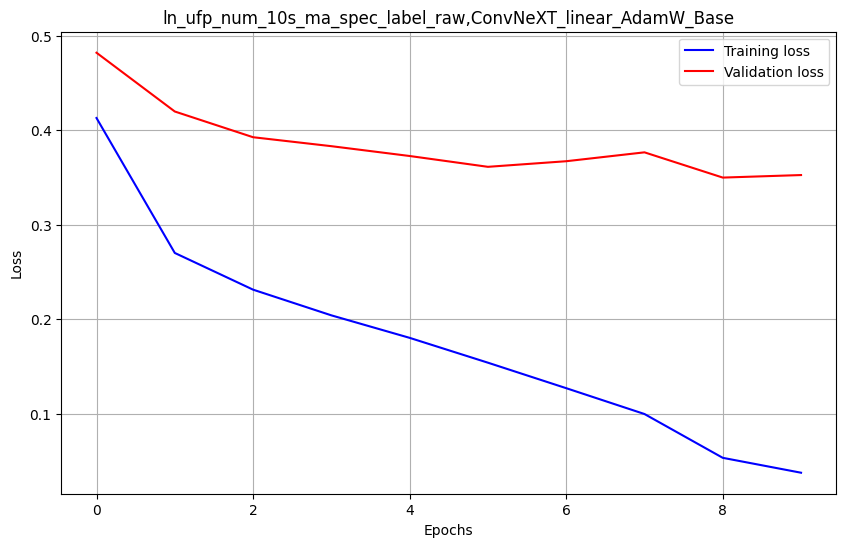

In [15]:
# Plotting the train validation curves
import matplotlib.pyplot as plt

# data = pd.read_csv(filepath_or_buffer='./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')

# # Extract data from DataFrame
# epochs = data['epoch']
# train_loss = data['loss']
# val_loss = data['val_loss']

# # Plotting loss curves
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title(f'{target},{architecture}')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

# Load data from CSV
data = pd.read_csv(filepath_or_buffer='./rishabh_model_files/logs/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024.csv')

# Extract data from DataFrame
epochs = data['epoch']
train_loss = data['loss']
val_loss = data['val_loss']

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title(f'{target},{architecture}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Setting y-axis ticks at intervals of 0.02
# max_loss = max(max(train_loss), max(val_loss))
# min_loss = min(min(train_loss), min(val_loss))
# plt.yticks(np.arange(min_loss, max_loss + 0.02, 0.02))

# plt.show()

In [38]:
##### Generate Predictions for compiled data, add them to dataframe, save new dataframe #####

#Load Metadata
metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_04252024.csv", low_memory=False)

# check to see if each image file exists and remove rows from the results dataframe for which image files don't exist.
metadata['file_exists'] = metadata.apply(lambda row: os.path.isfile(row.image_path), axis = 1)

#Remove missing files from metadata to avoid errors in adding predictions to dataframe
metadata = metadata.loc[metadata['file_exists'] == True]
metadata.head(10)

,datetime,image_path,audio_path,ln_ufp_num_10s_ma_image_label_raw,ln_ufp_num_10s_ma_spec_label_raw,ln_ufp_size_10s_ma_image_label_raw,ln_ufp_size_10s_ma_spec_label_raw,ln_noise_10s_ma_image_label_raw,ln_noise_10s_ma_spec_label_raw,ufp_num_10s_ma_image_label_raw,...,ufp_size_10s_ma_spec_label_quartile,ufp_size_10s_ma_image_label_quartile,image_extension,audio_extension,image_name,audio_name,pair_pm25,set_V3ext,set,vsby_nm
0,2019-04-23T10:20:27Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.744668,9.744668,3.098740,3.098740,4.319752,4.319752,17063.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
1,2019-04-23T10:20:28Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.710145,9.710145,3.119276,3.119276,4.309322,4.309322,16484.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
2,2019-04-23T10:20:29Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.683153,9.683153,3.144583,3.144583,4.327702,4.327702,16045.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
3,2019-04-23T10:20:30Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.583558,9.583558,3.167583,3.167583,4.320018,4.320018,14524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
4,2019-04-23T10:20:31Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.509259,9.509259,3.184698,3.184698,4.303119,4.303119,13484.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
5,2019-04-23T10:20:32Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.479069,9.479069,3.197448,3.197448,4.277360,4.277360,13083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
6,2019-04-23T10:20:33Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.422544,9.422544,3.211650,3.211650,4.273606,4.273606,12364.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
7,2019-04-23T10:20:34Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.399638,9.399638,3.223664,3.223664,4.260000,4.260000,12084.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
8,2019-04-23T10:20:35Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.403107,9.403107,3.235536,3.235536,4.227709,4.227709,12126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
9,2019-04-23T10:20:36Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.406976,9.406976,3.241029,3.241029,4.200804,4.200804,12173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0


In [39]:
metadata.set.value_counts()

set
trn    345680
val     22407
tst     22223
Name: count, dtype: int64

In [ ]:
# Generate Predictions and Add to Database

# Define Preprocessing functions
architecture_preprocessing_convnext = K.applications.convnext.preprocess_input

# Define Test Generators
generator_test_convnext = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing_convnext, 
                                                     horizontal_flip=False,
                                                     vertical_flip = False)

test_generator_convnext_audio = generator_test_convnext.flow_from_dataframe(dataframe=metadata[['audio_path']].reset_index(drop=True),
                                                     x_col= 'audio_path',
                                                     class_mode= None,
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

test_generator_convnext_image = generator_test_convnext.flow_from_dataframe(dataframe=metadata[['image_path']].reset_index(drop=True),
                                                     x_col= 'image_path',
                                                     class_mode= None,
                                                     target_size=(256, 256),
                                                     color_mode='rgb',
                                                     batch_size=64,
                                                     shuffle=False)

                                                                       
######### - Generate Predictions for Best CNN Models - ##############

# Best model for log(ufp_num) based on images:  ln_ufp_num, image, convnext, raw
print("Running predictions for: ln_ufp_num_convnext_image_raw_model")
ln_ufp_num_convnext_image_raw_model = load_model('rishabh_model_files/models/ln_ufp_num_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf')
metadata['ln_ufp_num_convnext_image_raw_prediction'] = ln_ufp_num_convnext_image_raw_model.predict(x=test_generator_convnext_image, 
                                                                                           steps=int(np.ceil(test_generator_convnext_image.samples/test_generator_convnext_image.batch_size)))
# Best model for log(ufp_num) based on audio: ln_ufp_num, audio, convnext, raw
print("Running predictions for: ln_ufp_num_convnext_audio_raw_model")
ln_ufp_num_convnext_audio_raw_model = load_model('rishabh_model_files/models/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf')
metadata['ln_ufp_num_convnext_audio_raw_prediction'] = ln_ufp_num_convnext_audio_raw_model.predict(x=test_generator_convnext_audio, 
                                                                                             steps=int(np.ceil(test_generator_convnext_audio.samples/test_generator_convnext_audio.batch_size)))
# Best model for log(ufp_size) based on images: ln_ufp_size, image, convnext, raw 
print("Running predictions for: ln_ufp_size_convnext_image_raw_model")
ln_ufp_size_convnext_image_raw_model = load_model('rishabh_model_files/models/ln_ufp_size_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf')
metadata['ln_ufp_size_convnext_image_raw_prediction'] = ln_ufp_size_convnext_image_raw_model.predict(x=test_generator_convnext_image, 
                                                                                             steps=int(np.ceil(test_generator_convnext_image.samples/test_generator_convnext_image.batch_size)))
# Best model for log(ufp_size) based on audio: ln_ufp_size, audio, convnext, raw
print("Running predictions for: ln_ufp_size_convnext_audio_raw_model")
ln_ufp_size_convnext_audio_raw_model = load_model('rishabh_model_files/models/ln_ufp_size_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf')
metadata['ln_ufp_size_convnext_audio_raw_prediction'] = ln_ufp_size_convnext_audio_raw_model.predict(x=test_generator_convnext_audio,
                                                                                                     steps=int(np.ceil(test_generator_convnext_audio.samples/test_generator_convnext_audio.batch_size)))
# Best model for log(noise) based on images: ln_noise, image, convnext, raw
print("Running predictions for: ln_noise_convnext_image_raw_model")
ln_noise_convnext_image_raw_model = load_model('rishabh_model_files/models/ln_noise_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf')
metadata['ln_noise_convnext_image_raw_prediction'] = ln_noise_convnext_image_raw_model.predict(x=test_generator_convnext_image,
                                                                                               steps=int(np.ceil(test_generator_convnext_image.samples/test_generator_convnext_image.batch_size)))
# Best model for log(noise) based on audio: ln_noise, audio, convnext, raw
print("Running predictions for: ln_noise_convnext_audio_raw_model")
ln_noise_convnext_audio_raw_model = load_model('rishabh_model_files/models/ln_noise_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024.tf')
metadata['ln_noise_convnext_audio_raw_prediction'] = ln_noise_convnext_audio_raw_model.predict(x=test_generator_convnext_audio, 
                                                                                             steps=int(np.ceil(test_generator_convnext_audio.samples/test_generator_convnext_audio.batch_size)))               

# Save dataframe with all predictions added
metadata.to_csv(path_or_buf='compiled data/rishabh/metadata_gopro_training_only_UFP_V2_V3_04252024_predictions_added.csv', index=False)


Found 390310 validated image filenames.
Found 390310 validated image filenames.
Running predictions for: ln_ufp_num_convnext_image_raw_model
6099/6099 [==============================] - 6750s 1s/step
Running predictions for: ln_ufp_num_convnext_audio_raw_model
4591/6099 [=====================>........] - ETA: 19:58